dict_keys(['__header__', '__version__', '__globals__', 'paviaU'])


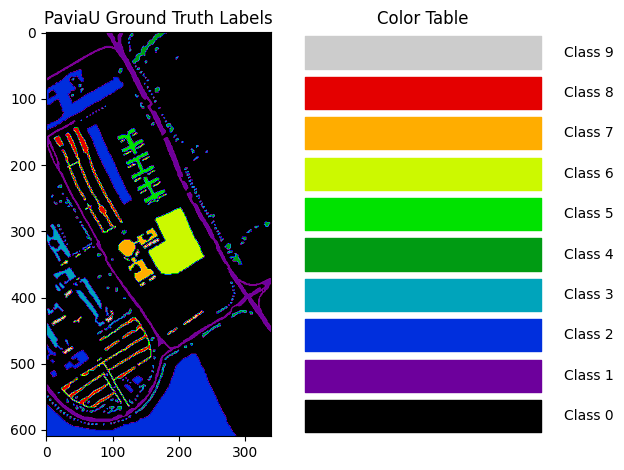

The shape of PaviaU: 
 (610, 340, 103)
The number of all pixels:  207400
最佳n_estimators是100,选择了51个特征


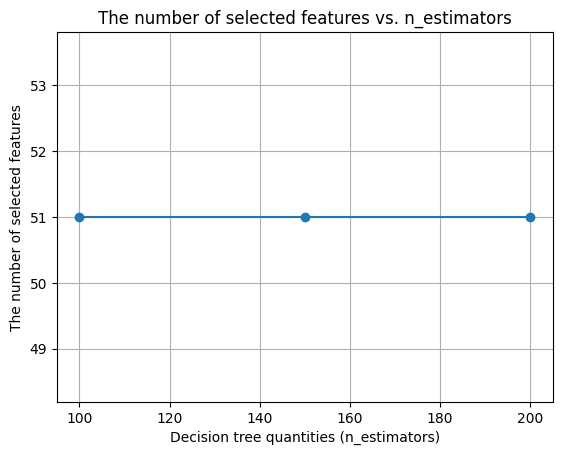

过滤之后数据的形状为:  (42776, 51)
                   Mean  Standard Deviation  Variance
Feature 1    877.592248          705.881023     691.5
Feature 2    877.524313          726.748267     687.0
Feature 3    886.931387          751.663472     687.0
Feature 4    898.750327          775.733302     695.0
Feature 5    895.497148          789.084365     693.0
Feature 6    897.914064          805.693061     694.0
Feature 7    905.671498          820.408748     700.0
Feature 8    913.709416          830.272882     705.0
Feature 9    917.896671          836.277121     708.0
Feature 10   928.372966          842.469682     722.0
Feature 11   940.207032          845.039794     739.0
Feature 12   951.967271          842.566194     755.0
Feature 13   966.500912          838.659959     774.0
Feature 14   982.894661          832.248423     794.0
Feature 15  1004.499252          823.608887     819.0
Feature 16  1050.604264          799.395227     868.0
Feature 17  1129.135122          774.739307     952.0
Fea

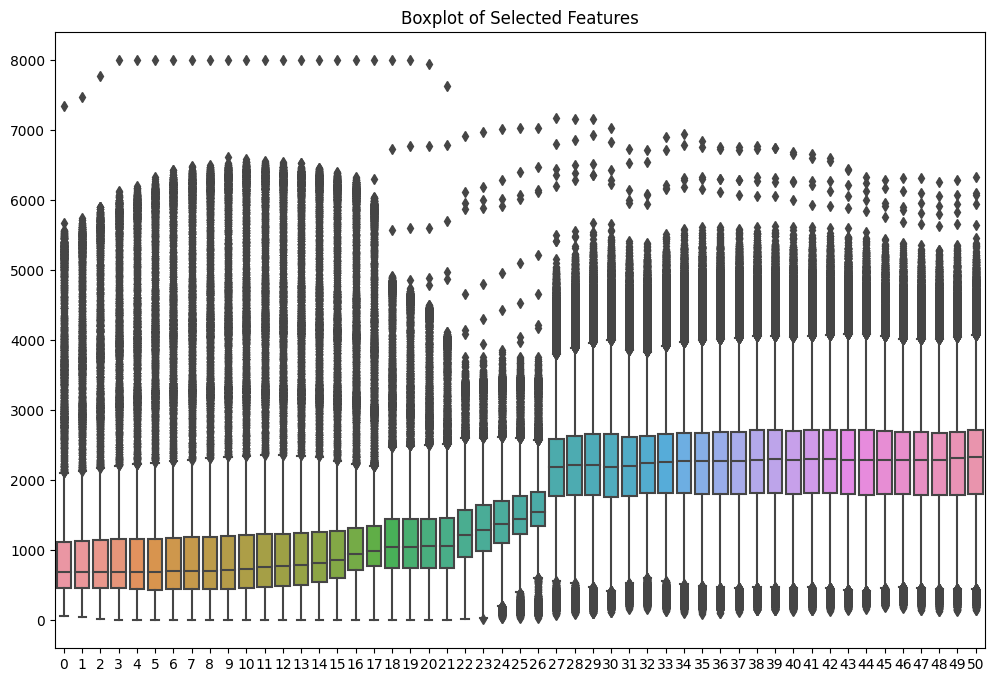

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier

matlab_data = scipy.io.loadmat('C:\\Users\\30674\\Desktop\\dts201 pattern revognition\\Team Coursework\\DTS201TC CW DATASET\\PaviaU')
print(matlab_data.keys())
paviaU_data = matlab_data['paviaU']

mat_label = scipy.io.loadmat('C:\\Users\\30674\\Desktop\\dts201 pattern revognition\\Team Coursework\\DTS201TC CW DATASET\\PaviaU_gt')
paviaU_gt = mat_label["paviaU_gt"]

# Displaying the band of PaviaU data
plt.subplot(1, 2, 1)
plt.imshow(paviaU_gt, cmap='nipy_spectral')
plt.title("PaviaU Ground Truth Labels")

# Color table
unique_labels_all = np.unique(paviaU_gt)
colors_all = plt.cm.nipy_spectral(np.linspace(0, 1, len(unique_labels_all)))

plt.subplot(1, 2, 2)
for idx, (label, color) in enumerate(zip(unique_labels_all, colors_all)):
    plt.fill_between([0, 1], idx + 0.1, idx + 0.9, color=color)
    plt.text(1.1, idx + 0.5, f'Class {label}', va='center')
plt.ylim(0, len(unique_labels_all))
plt.axis('off')
plt.title("Color Table")

plt.tight_layout()
plt.show()

# Fisher's linear discriminant
# 610纵向像素数,340横向像素数,每个像素都有103个不同波段或者特征的值
print('The shape of PaviaU: \n', paviaU_data.shape)

num_pixels = paviaU_data.shape[0] * paviaU_gt.shape[1]
print('The number of all pixels: ', num_pixels)
num_features = paviaU_data.shape[2]

# Reshape the PaviaU data to be two-dimensional
paviaU_2D = paviaU_data.reshape((num_pixels, num_features))

# We will only take pixels where ground truth labels are not equal to zero
non_zero_labels = paviaU_gt.reshape(num_pixels) != 0
paviaU_2D_non_zero = paviaU_2D[non_zero_labels]

# 获取所有非零标签的像素的标签值，并存储在一个一维数组中
paviaU_gt_non_zero = paviaU_gt.reshape(num_pixels)[non_zero_labels]

# 使用随机森林分类器获取特征重要性
best_n_estimators = 100
best_num_features = 0
num_features_list = []
best_select_features = None

for n in range(100,201,50):
    rf = RandomForestClassifier(n_estimators=n)
    rf.fit(paviaU_2D_non_zero, paviaU_gt_non_zero)

    # 获取特征重要性
    feature_importance = rf.feature_importances_

    # 为特征选择一个阈值
    threshold = np.median(feature_importance)

    # 基于阈值选择特征
    selected_features = np.where(feature_importance > threshold)[0]

    num_features_list.append(len(selected_features))

    # 检查n_estimators是否给出了更多的选定特征
    if len(selected_features) > best_num_features:
        best_num_features = len(selected_features)
        best_n_estimators = n
        best_select_features = selected_features

print(f"最佳n_estimators是{best_n_estimators},选择了{best_num_features}个特征")

# Visualize
plt.plot(range(100, 201, 50), num_features_list, marker='o', linestyle='-')
plt.xlabel('Decision tree quantities (n_estimators)')
plt.ylabel('The number of selected features')
plt.title('The number of selected features vs. n_estimators')
plt.grid(True)
plt.show()

# 过滤数据以仅包括所选特征
paviaU_2D_non_zero = paviaU_2D_non_zero[:, best_select_features]
print('过滤之后数据的形状为: ', paviaU_2D_non_zero.shape)

# 将NumPy数组转换为Pandas DataFrame
df = pd.DataFrame(paviaU_2D_non_zero, columns=[f'Feature {i+1}' for i in range(paviaU_2D_non_zero.shape[1])])

# 计算统计量
stats = df.describe().transpose()[['mean', 'std', '50%']]
stats.columns = ['Mean', 'Standard Deviation', 'Variance']
print(stats.to_string())

# Select the feature
mean_values = np.mean(paviaU_2D_non_zero, axis=0)
variance_values = np.var(paviaU_2D_non_zero, axis=0)
std_dev_values = np.std(paviaU_2D_non_zero, axis=0)

# 输出统计值
print(f'Mean values: {mean_values}')
print(f'Variance values: {variance_values}')
print(f'Standard deviation values: {std_dev_values}')

# 为每个特征绘制箱线图
plt.figure(figsize=(12, 8))
sns.boxplot(data=paviaU_2D_non_zero)
plt.title('Boxplot of Selected Features')
plt.show()